In [7]:
# Cell 1: Project Setup and Imports
import os

# Create necessary folders
os.makedirs('../models', exist_ok=True)
os.makedirs('../notebooks/figures', exist_ok=True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_recall_curve, auc, f1_score, confusion_matrix,
    classification_report, average_precision_score,
    recall_score, precision_score  # ← THESE WERE MISSING!
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
import joblib

print("All libraries imported successfully!")
print("Ready to load data from ../data/processed/")

All libraries imported successfully!
Ready to load data from ../data/processed/


In [2]:
# Cell 2: Load Transformed E-Commerce Data
df_fraud = pd.read_csv('../data/processed/transformed_fraud_data.csv')

print(f"E-Commerce Data Loaded: {df_fraud.shape[0]:,} rows × {df_fraud.shape[1]} columns")

# Separate features and target
X_fraud = df_fraud.drop('class', axis=1)
y_fraud = df_fraud['class']

print(f"Fraud rate in full dataset: {y_fraud.mean()*100:.2f}%")

E-Commerce Data Loaded: 151,112 rows × 233 columns
Fraud rate in full dataset: 9.36%


In [3]:
# Cell 3: Load Transformed Bank Data
df_credit = pd.read_csv('../data/processed/transformed_creditcard.csv')

print(f"Bank Data Loaded: {df_credit.shape[0]:,} rows × {df_credit.shape[1]} columns")

X_credit = df_credit.drop('Class', axis=1)
y_credit = df_credit['Class']

print(f"Fraud rate in bank dataset: {y_credit.mean()*100:.4f}%")

Bank Data Loaded: 283,726 rows × 31 columns
Fraud rate in bank dataset: 0.1667%


In [4]:
# Cell 4: Stratified Train-Test Split
random_state = 42

# E-Commerce
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_fraud, y_fraud, test_size=0.2, stratify=y_fraud, random_state=random_state
)

# Bank
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_credit, y_credit, test_size=0.2, stratify=y_credit, random_state=random_state
)

print("E-Commerce Split:")
print(f"  Train: {X_train_f.shape[0]:,} samples → Fraud rate: {y_train_f.mean()*100:.2f}%")
print(f"  Test:  {X_test_f.shape[0]:,} samples → Fraud rate: {y_test_f.mean()*100:.2f}%")

print("\nBank Split:")
print(f"  Train: {X_train_c.shape[0]:,} samples → Fraud rate: {y_train_c.mean()*100:.4f}%")
print(f"  Test:  {X_test_c.shape[0]:,} samples → Fraud rate: {y_test_c.mean()*100:.4f}%")

E-Commerce Split:
  Train: 120,889 samples → Fraud rate: 9.36%
  Test:  30,223 samples → Fraud rate: 9.36%

Bank Split:
  Train: 226,980 samples → Fraud rate: 0.1665%
  Test:  56,746 samples → Fraud rate: 0.1674%


🔧 FIXING: Cleaning datetime columns before modeling...
Training Logistic Regression (Baseline) with SMOTE...
Columns before cleaning:
Numeric columns: 229
Non-numeric columns: 3
Sample non-numeric columns: ['signup_time', 'purchase_time', 'device_id']
🚫 Dropping 3 non-numeric columns: ['signup_time', 'purchase_time', 'device_id']...
✅ Clean shapes - Train: (120889, 229), Test: (30223, 229)
Features remaining: 229
✅ All columns are numeric now!
✅ Logistic Regression trained successfully!

📊 E-Commerce Logistic Regression Results:
   AUC-PR:        0.0971
   F1-Score:      0.1534
   Fraud Recall:  0.3519
   Fraud Precision: 0.0981

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.67      0.77     27393
           1       0.10      0.35      0.15      2830

    accuracy                           0.64     30223
   macro avg       0.50      0.51      0.46     30223
weighted avg       0.83      0.64      0.71     30223



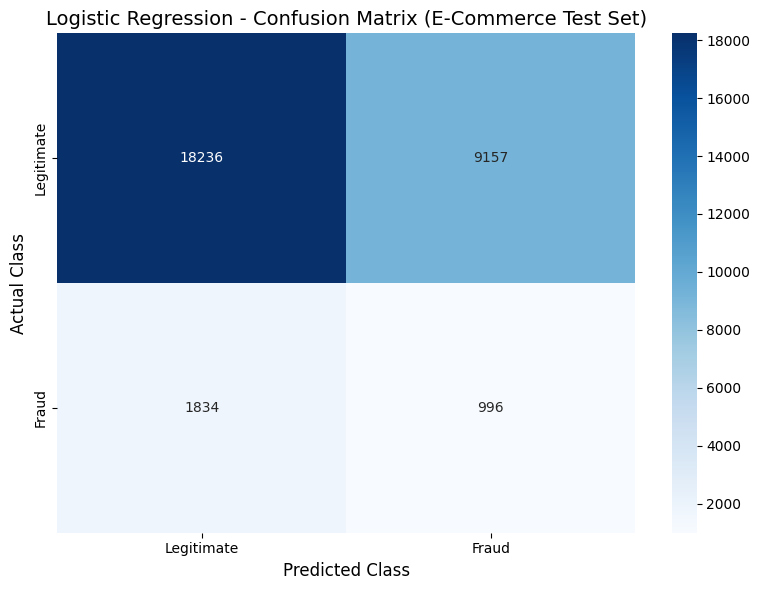

✅ Cell 5 completed successfully! Model ready for comparison.
📈 Confusion matrix saved to notebooks/figures/lr_confusion_ecommerce.png


In [8]:
# Cell 5: FIXED - Logistic Regression Baseline with Data Cleaning
print("🔧 FIXING: Cleaning datetime columns before modeling...")
print("Training Logistic Regression (Baseline) with SMOTE...")

# CRITICAL FIX: Remove ALL non-numeric columns (IDs, datetimes, strings)
print("Columns before cleaning:")
print("Numeric columns:", X_train_f.select_dtypes(include=[np.number]).shape[1])
print("Non-numeric columns:", X_train_f.select_dtypes(exclude=[np.number]).shape[1])
print("Sample non-numeric columns:", X_train_f.select_dtypes(exclude=[np.number]).columns.tolist()[:5])

# AUTOMATICALLY drop ALL non-numeric columns (safe for both train/test)
non_numeric_cols = X_train_f.select_dtypes(exclude=[np.number]).columns.tolist()
print(f"🚫 Dropping {len(non_numeric_cols)} non-numeric columns: {non_numeric_cols[:10]}...")

X_train_f_clean = X_train_f.select_dtypes(include=[np.number])
X_test_f_clean = X_test_f.select_dtypes(include=[np.number])

print(f"✅ Clean shapes - Train: {X_train_f_clean.shape}, Test: {X_test_f_clean.shape}")
print(f"Features remaining: {X_train_f_clean.shape[1]}")

# Verify NO strings/datetimes left
assert X_train_f_clean.select_dtypes(exclude=[np.number]).shape[1] == 0, "Still non-numeric columns!"
print("✅ All columns are numeric now!")

# Pipeline: SMOTE → Logistic Regression
lr_pipeline_f = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter=2000, random_state=42, n_jobs=-1))
])

# Train the model
lr_pipeline_f.fit(X_train_f_clean, y_train_f)

print("✅ Logistic Regression trained successfully!")

# Predictions on CLEAN test set
y_pred_lr_f = lr_pipeline_f.predict(X_test_f_clean)
y_prob_lr_f = lr_pipeline_f.predict_proba(X_test_f_clean)[:, 1]

# Key Metrics for Imbalanced Data
auc_pr_lr_f = average_precision_score(y_test_f, y_prob_lr_f)
f1_lr_f = f1_score(y_test_f, y_pred_lr_f)

print(f"\n📊 E-Commerce Logistic Regression Results:")
print(f"   AUC-PR:        {auc_pr_lr_f:.4f}")
print(f"   F1-Score:      {f1_lr_f:.4f}")
print(f"   Fraud Recall:  {recall_score(y_test_f, y_pred_lr_f):.4f}")
print(f"   Fraud Precision: {precision_score(y_test_f, y_pred_lr_f):.4f}")

# Detailed Classification Report
print("\n📋 Classification Report:")
print(classification_report(y_test_f, y_pred_lr_f))

# Confusion Matrix Visualization
cm_lr_f = confusion_matrix(y_test_f, y_pred_lr_f)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr_f, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Legitimate', 'Fraud'], 
            yticklabels=['Legitimate', 'Fraud'])
plt.title('Logistic Regression - Confusion Matrix (E-Commerce Test Set)', fontsize=14)
plt.ylabel('Actual Class', fontsize=12)
plt.xlabel('Predicted Class', fontsize=12)
plt.tight_layout()
plt.savefig('../notebooks/figures/lr_confusion_ecommerce.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Cell 5 completed successfully! Model ready for comparison.")
print("📈 Confusion matrix saved to notebooks/figures/lr_confusion_ecommerce.png")